In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

from keras import layers
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.models import Model
from keras import Sequential

        

2022-08-04 18:06:10.822227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-04 18:06:10.822286: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
NOISE_FACTOR = 0.5
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28

np.random.seed = 20


def preproc(imgArr):
    imgArr = imgArr.astype("float32") / 255.0
    imgArr = np.reshape(imgArr, (len(imgArr), IMAGE_HEIGHT, IMAGE_WIDTH, 1))
    return imgArr

def addGaussianNoise(imgArr, noiseFactor):
    if noiseFactor < 0:
        raise Exception("Specify a positive noise factor")
    
    imgNoisyArr = imgArr + noiseFactor * np.random.normal(loc=0.0, scale=1, size=imgArr.shape)
    return np.clip(imgNoisyArr, 0.0, 1.0)

def showImgArrays(arr1, arr2, num):
    if len(arr1) != len(arr2):
        raise Exception("Array 1 and array 2 must have the same length")
    if num > len(arr1):
        raise Exception("The number of elements to return must be lower than the array length")
    
    indexes = np.random.randint(len(arr1), size=num)
    imgArr1 = arr1[indexes, :]
    imgArr2 = arr2[indexes, :]
    
    plt.figure(figsize=(20, 4))
    for i, (img1, img2) in enumerate(zip(imgArr1, imgArr2)):
        ax = plt.subplot(2, num, i + 1)
        plt.imshow(img1.reshape(IMAGE_HEIGHT, IMAGE_WIDTH))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, num, i + 1 + num)
        plt.imshow(img2.reshape(IMAGE_HEIGHT, IMAGE_WIDTH))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

4431872/4422102 [==============================] - 1s 0us/step


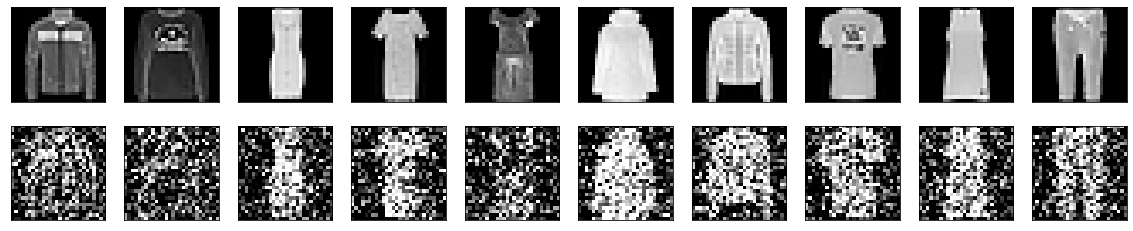

In [3]:
#(trainingSet, _), (testSet, _) = mnist.load_data()
(trainingSet, _), (testSet, _) = fashion_mnist.load_data()

# Normalize and reshape data
trainingSet = preproc(trainingSet)
testSet = preproc(testSet)

noisyTrainingSet = addGaussianNoise(trainingSet, noiseFactor=NOISE_FACTOR)
noisyTestSet = addGaussianNoise(testSet, noiseFactor=NOISE_FACTOR)

showImgArrays(trainingSet, noisyTrainingSet, 10)


2022-08-04 18:06:34.239160: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-04 18:06:34.239201: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-04 18:06:34.239228: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dosclic98-350V5C-351V5C-3540VC-3440VC): /proc/driver/nvidia/version does not exist


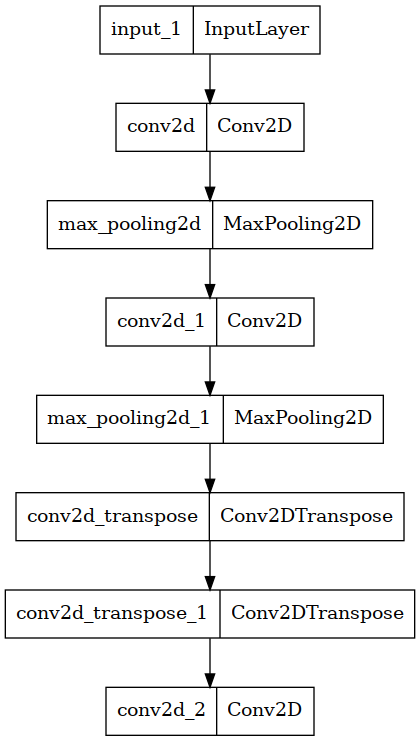

In [4]:
input = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1))

# Encoder
e1 = layers.Conv2D(32, (3,3), activation="relu", padding="same")(input)
e2 = layers.MaxPooling2D((2,2), padding="same")(e1)
e3 = layers.Conv2D(32, (3,3), activation="relu", padding="same")(e2)
e4 = layers.MaxPooling2D((2,2), padding="same")(e3)

# Decoder
d5 = layers.Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(e4)
d6 = layers.Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(d5)
d7 = layers.Conv2D(1, (3,3), activation="sigmoid", padding="same")(d6)

# Autoencoder
autoencoder = Model(input, d7)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

plot_model(autoencoder)


In [5]:
autoencoder.fit(
    x=trainingSet,
    y=trainingSet,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(testSet, testSet),
)

2022-08-04 18:06:34.713400: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2022-08-04 18:06:34.859860: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/50
 25/469 [>.............................] - ETA: 2:04 - loss: 0.6487

KeyboardInterrupt: 

In [ ]:
predictions = autoencoder.predict(testSet)
showImgArrays(testSet, predictions, 10)

In [ ]:
# Save the model
autoencoder.save("modelAutoencoder.h5")

In [ ]:
autoencoder.fit(
    x=noisyTrainingSet,
    y=trainingSet,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(noisyTestSet, testSet),
)

In [ ]:
predictions = autoencoder.predict(noisyTestSet)
showImgArrays(noisyTestSet, predictions, 10)

In [ ]:
# Save the model
autoencoder.save("modelAutoencoderNoisy.h5")